# **Installing pyspark**

In [1]:
# Importing necessary libraries
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5ef137ae0dca9ddf8df78a3f1d9a2401ee9b90e490f4ce1d7b819d79afb41288
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **Import necessary libraries and initiation spark session.**

In [2]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Load and preprocess data
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction").getOrCreate()

## **1.	Data set and Exploration:**

# **Use the dataset provided (Telecom_Churn.csv).**

In [3]:
df_churn = spark.read.csv("/content/sample_data/telecom_churn.csv", header=True, inferSchema=True)

# **Explore** the data to understand its distribution

In [4]:
# Explore the data
print("First 5 rows of the dataset:")
df_churn.show(5)

First 5 rows of the dataset:
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|    

In [5]:
print("\nSchema of the dataset:")
df_churn.printSchema()


Schema of the dataset:
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
print("Column names in the DataFrame:")
print(df_churn.columns)

Column names in the DataFrame:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [7]:
# Print the Total number of customer records
print("Total number of customer records:", df_churn.count())

# Print the Total number of features
print("Total number of features:", len(df_churn.columns))

Total number of customer records: 7043
Total number of features: 21


In [8]:
# Print the schema of the dataset
print("Schema of the dataset:")
df_churn.printSchema()

# Print summary statistics of numerical columns
numeric_cols = [col for col, data_type in df_churn.dtypes if data_type != 'string']
print("Summary statistics of numerical columns:")
df_churn.select(numeric_cols).describe().show()

# Count and print the unique values in each categorical column
categorical_cols = [col for col, data_type in df_churn.dtypes if data_type == 'string']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df_churn.select(col).distinct().rdd.map(lambda row: row[0]).collect())
    print()

Schema of the dataset:
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

Summary statistics of numerical columns:
+-------+--------

In [9]:
# Get summary statistics for all columns
df_churn.describe().show()

+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|              7043|   7043|      7043|     

# **identify missing values**

In [10]:
from pyspark.sql.functions import when, col

# Convert blank spaces to NaN for all string columns
for col_name in [col for col, data_type in df_churn.dtypes if data_type == 'string']:
    df_churn = df_churn.withColumn(col_name, when(col(col_name) == ' ', None).otherwise(col(col_name)))

# Convert blank spaces to NaN for all numeric columns
for col_name in [col for col, data_type in df_churn.dtypes if data_type != 'string']:
    df_churn = df_churn.withColumn(col_name, when(col(col_name).cast('string') == ' ', float('nan')).otherwise(col(col_name)))

In [11]:
# Check for missing values
print("Missing values in the dataset:")
for column in df_churn.columns:
    num_missing = df_churn.where(df_churn[column].isNull()).count()
    if num_missing > 0:
        print(f"{column}: {num_missing} missing values")

Missing values in the dataset:
TotalCharges: 11 missing values


# **converting total charges and montly charges to float**

In [12]:
from pyspark.sql.functions import col

# Convert TotalCharges from string to float
df_churn = df_churn.withColumn("TotalCharges", col("TotalCharges").cast("float"))

# Convert MonthlyCharges from double to float
df_churn = df_churn.withColumn("MonthlyCharges", col("MonthlyCharges").cast("float"))

In [13]:
print("\nSchema of the dataset:")
df_churn.printSchema()


Schema of the dataset:
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



# **Checking for duplicates in dataset**

In [14]:
# Check for duplicates
duplicate_rows = df_churn.select("*").distinct().count() != df_churn.count()

if duplicate_rows:
    print("Duplicate rows found in the dataset.")
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


## **Identifying categorical and numerical varaibles**

In [15]:
from pyspark.sql.types import StringType, NumericType

# Function to identify categorical and numerical columns
def get_column_types(df):
    column_types = {}
    for column in df.columns:
        column_type = df.schema[column].dataType
        if isinstance(column_type, StringType):
            column_types[column] = "categorical"
        elif isinstance(column_type, NumericType):
            column_types[column] = "numerical"
        else:
            column_types[column] = "other"
    return column_types

# Get the column types
column_types = get_column_types(df_churn)

# Print the categorical and numerical columns
print("Categorical columns:")
for column, column_type in column_types.items():
    if column_type == "categorical":
        print(column)

print("\nNumerical columns:")
for column, column_type in column_types.items():
    if column_type == "numerical":
        print(column)

Categorical columns:
customerID
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
Churn

Numerical columns:
SeniorCitizen
tenure
MonthlyCharges
TotalCharges


# **Outliers**

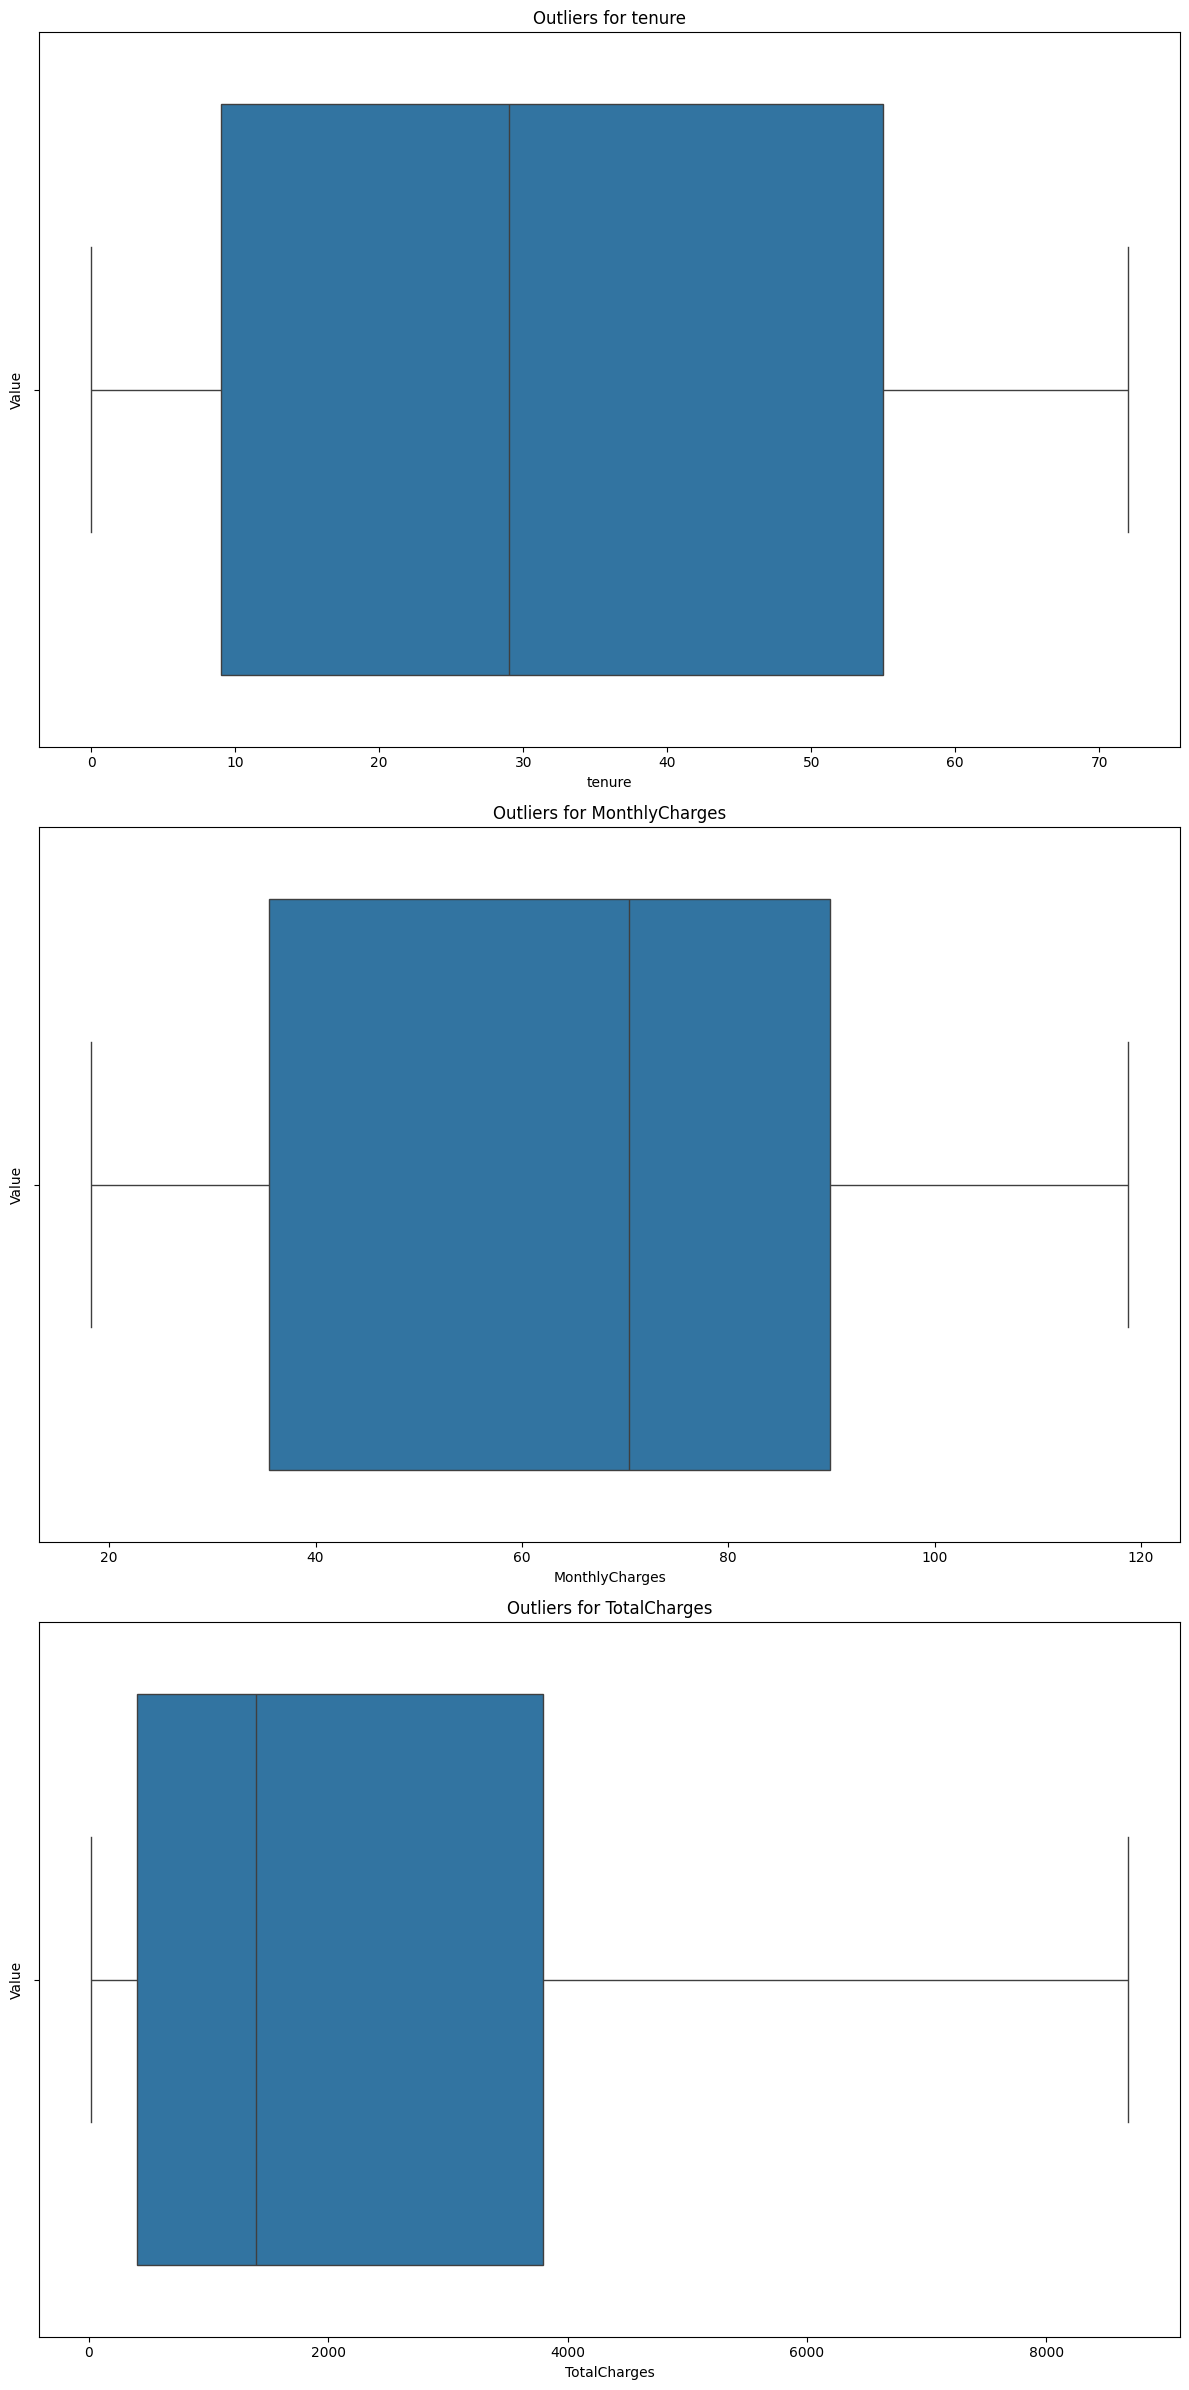

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pdf_churn = df_churn.toPandas()

# Define the numerical columns excluding 'SeniorCitizen'
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot outliers for numerical columns
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 8 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=col, data=pdf_churn, ax=axes[i])
    axes[i].set_title(f"Outliers for {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

# **correlations between different features**

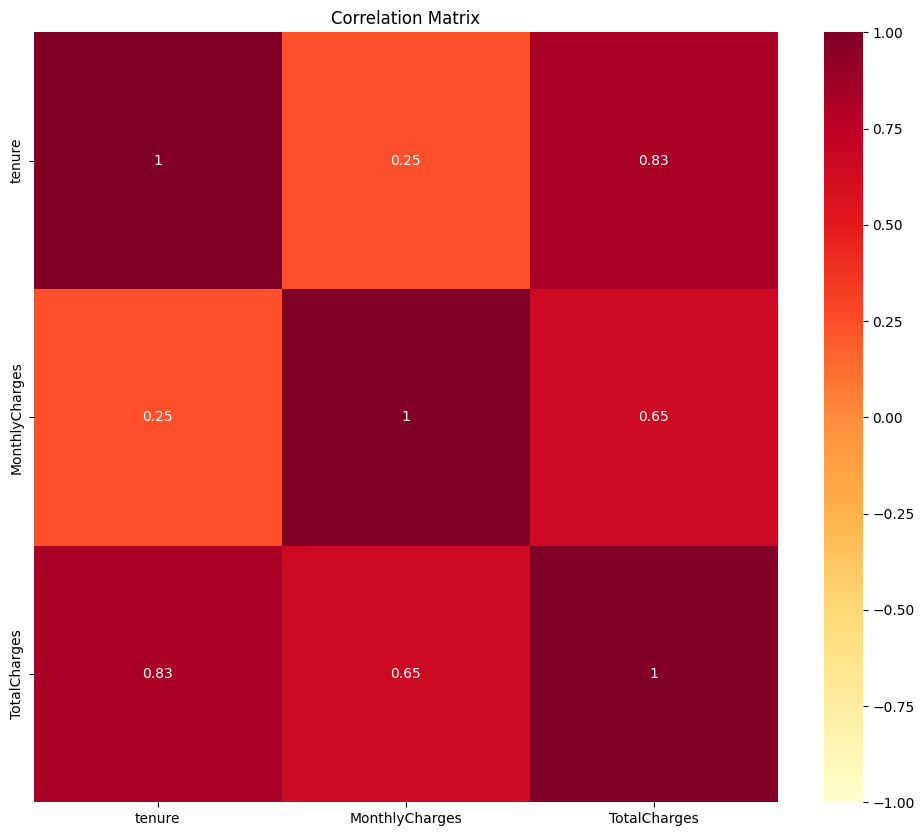

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pdf_churn = df_churn.toPandas()

# Calculate the correlation matrix
if 'senior_citizen' in pdf_churn.columns:
    corr_matrix = pdf_churn[numerical_cols + ['senior_citizen']].corr()
else:
    corr_matrix = pdf_churn[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## **Data Visualization for categorical variables:**

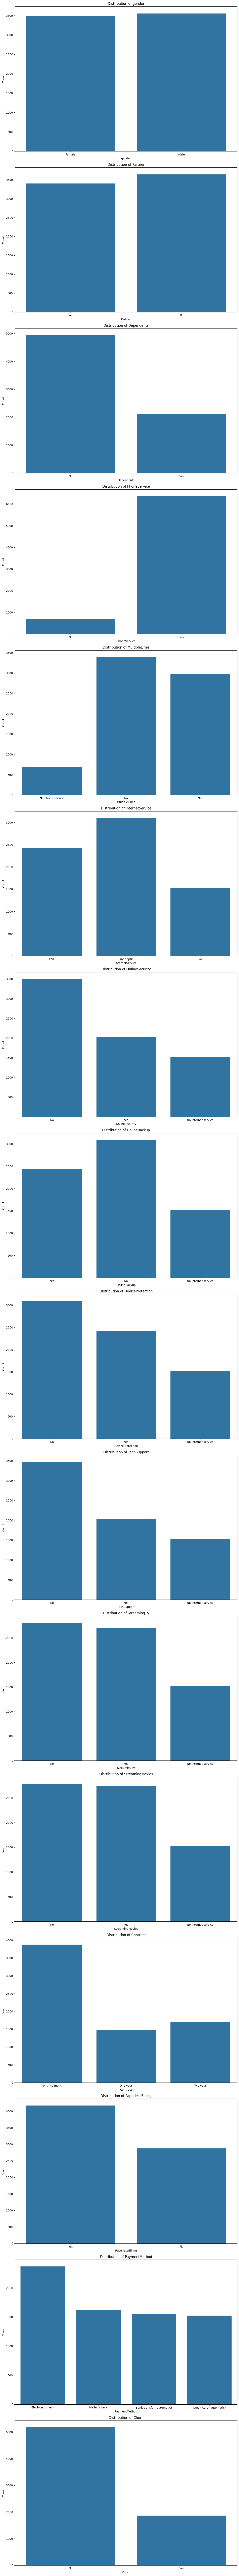

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pdf_churn = df_churn.toPandas()

# Identify categorical and numerical columns
categorical_cols = [col for col, data_type in df_churn.dtypes if data_type == 'string' and col != 'customerID']
numerical_cols = [col for col, data_type in df_churn.dtypes if data_type != 'string']

# Plot graphs for categorical columns
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 8 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=pdf_churn, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

# **Histogram for numerical variables**

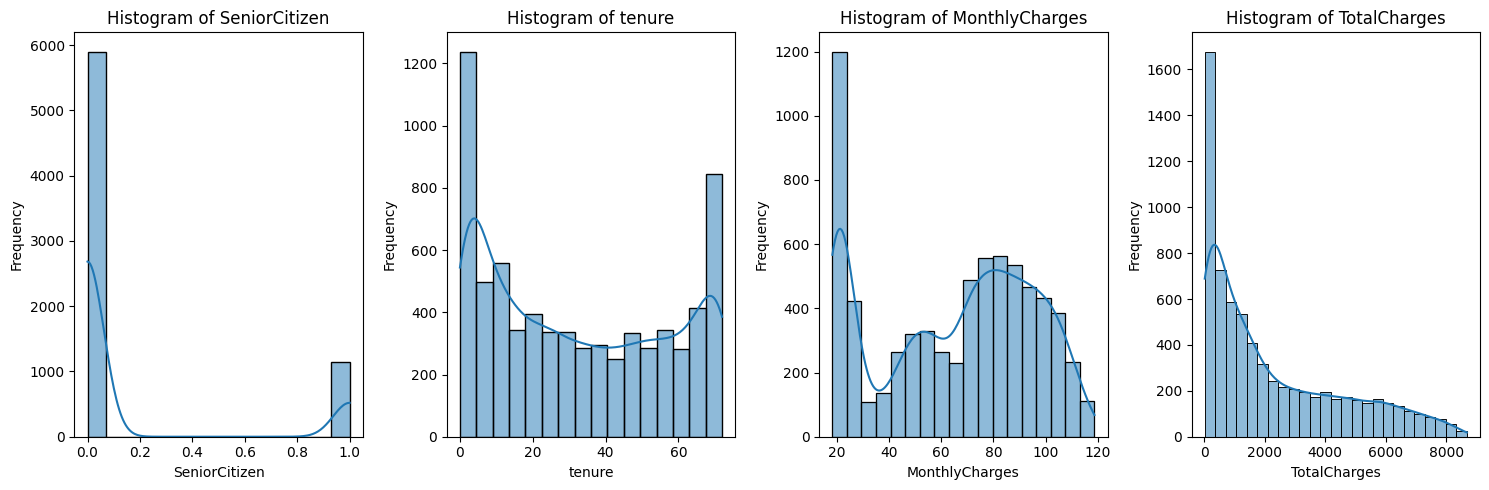

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pdf_churn = df_churn.toPandas()

# Identify categorical and numerical columns
categorical_cols = [col for col, data_type in df_churn.dtypes if data_type == 'string' and col != 'customerID']
numerical_cols = [col for col, data_type in df_churn.dtypes if data_type != 'string' and col != 'senior_citizen' and col != 'customerID']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(15, 5))

# Plot histograms with KDE
for i, var in enumerate(numerical_cols):
    sns.histplot(data=pdf_churn, x=var, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# **2.	Data Preprocessing:**

# **Preprocess the data by handling missing values**

In [20]:
print("\nSchema of the dataset:")
df_churn.printSchema()


Schema of the dataset:
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



In [21]:
# Explore the data
print("First 5 rows of the dataset:")
df_churn.show(5)

First 5 rows of the dataset:
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|          0.0|    Yes|        No|   1.0|          No|No phone service|            DSL|            No|         Yes|    

# **Replacing 11 missing values in total charges with median**

In [22]:
from pyspark.ml.feature import Imputer

# Create an Imputer object
imputer = Imputer(inputCols=['TotalCharges'], outputCols=['TotalCharges_imputed'])

# Set the strategy to 'median' to fill missing values with the median
imputer.setStrategy('median')

# Fit the Imputer and transform the DataFrame
df_churn_imputed = imputer.fit(df_churn).transform(df_churn)

# Drop the original 'TotalCharges' column and rename 'TotalCharges_imputed' to 'TotalCharges'
df_churn_imputed = df_churn_imputed.drop('TotalCharges').withColumnRenamed('TotalCharges_imputed', 'TotalCharges')

In [23]:
# Check for missing values
print("Missing values in the dataset:")
for column in df_churn_imputed.columns:
    num_missing = df_churn_imputed.where(df_churn_imputed[column].isNull()).count()
    if num_missing >= 0:
        print(f"{column}: {num_missing} missing values")

Missing values in the dataset:
customerID: 0 missing values
gender: 0 missing values
SeniorCitizen: 0 missing values
Partner: 0 missing values
Dependents: 0 missing values
tenure: 0 missing values
PhoneService: 0 missing values
MultipleLines: 0 missing values
InternetService: 0 missing values
OnlineSecurity: 0 missing values
OnlineBackup: 0 missing values
DeviceProtection: 0 missing values
TechSupport: 0 missing values
StreamingTV: 0 missing values
StreamingMovies: 0 missing values
Contract: 0 missing values
PaperlessBilling: 0 missing values
PaymentMethod: 0 missing values
MonthlyCharges: 0 missing values
Churn: 0 missing values
TotalCharges: 0 missing values


In [24]:
# Explore the data
print("First 5 rows of the dataset:")
df_churn_imputed.show(5)

First 5 rows of the dataset:
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+-----+------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|Churn|TotalCharges|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+-----+------------+
|7590-VHVEG|Female|          0.0|    Yes|        No|   1.0|          No|No phone service|            DSL|            No|         Yes|    

# **encoding categorical variables, and scaling numerical features as required and Perform feature engineering to create new features or transform existing ones that may be more informative for predicting churn.**

In [25]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Drop the 'customerID' column
df_churn_imputed = df_churn_imputed.drop('customerID')

# Categorical columns
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Numerical columns
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in cat_cols]

# OneHotEncoder for indexed categorical columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in cat_cols]

# Assemble encoded categorical columns and numerical columns into a single feature vector
assembler_inputs = [col+"_encoded" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# StandardScaler for numerical features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(df_churn_imputed)

# Transform the data
df_transformed = pipeline_model.transform(df_churn_imputed)

# Select only the necessary columns
selected_cols = ['features', 'scaled_features', 'Churn']
df_final = df_transformed.select(selected_cols)

# Show the transformed DataFrame
df_final.show(5, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                        |scaled_features                                                                                                                                                                                                                                                             

# **3.	Model Development**

In [26]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

# Convert 'Churn' column from string to numerical format
indexer = StringIndexer(inputCol="Churn", outputCol="label")
df_final = indexer.fit(df_final).transform(df_final)

# Split the data into training and testing sets
(train_data, test_data) = df_final.randomSplit([0.7, 0.3], seed=42)

# Initialize Random Forest classifier
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", seed=42)

# Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator()

# Define cross-validator with 5-fold cross-validation
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=42)

# Fit cross-validator to training data
cv_model = cv.fit(train_data)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions on test data
predictions = best_model.transform(test_data)

# Evaluate model performance
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Area Under ROC Curve (AUC):", auc)

# Show best parameters
print("Best Parameters:")
print("Num Trees:", best_model.getNumTrees)
print("Max Depth:", best_model.getOrDefault("maxDepth"))


Area Under ROC Curve (AUC): 0.8272455994560693
Best Parameters:
Num Trees: 150
Max Depth: 5


# **4.	Model Evaluation**

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy:", accuracy)

# Define MulticlassClassificationEvaluator for precision, recall, F1-score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision:", precision)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall:", recall)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1-score:", f1_score)

# Evaluate ROC-AUC score
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print("ROC-AUC Score:", roc_auc)


Accuracy: 0.7932237169905332
Precision: 0.7739606340919272
Recall: 0.7932237169905331
F1-score: 0.7733740340337372
ROC-AUC Score: 0.8272455994560693


# **Visualize the model's performance using techniques like ROC curves and confusion matrices to gain insights into its strengths and weaknesses.**

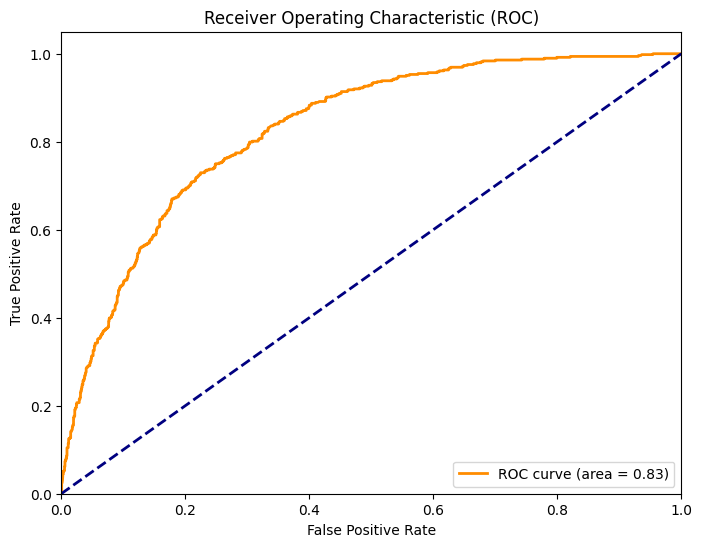

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.select("label", "probability").toPandas()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(predictions_pd["label"], predictions_pd["probability"].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


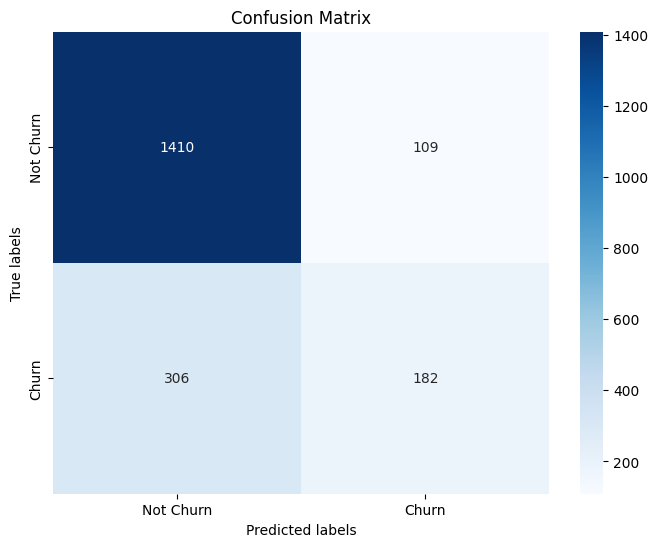

In [29]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for confusion matrix
predictions_pd = predictions.select("label", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=["Not Churn", "Churn"],
            yticklabels=["Not Churn", "Churn"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# **5.	Deployment and Interpretability:**

In [30]:
import pickle

# Get the model parameters
model_params = best_model.extractParamMap()

# Save the model parameters
with open('best_model_params.pkl', 'wb') as f:
    pickle.dump(model_params, f)

In [31]:
import pickle

with open('best_model_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

print(loaded_params)

{Param(parent='RandomForestClassifier_f6338395b05c', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_f6338395b05c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_f6338395b05c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_f6338395b05c', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Support

In [32]:
import pickle
from pyspark.ml.classification import RandomForestClassifier

# Load the saved model parameters
with open('best_model_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

# Create a new RandomForestClassifier instance
loaded_model = RandomForestClassifier()

# Convert Param objects to parameter name strings
param_dict = {param.name: value for param, value in loaded_params.items()}

# Set the loaded parameters on the new model
loaded_model.setParams(**param_dict)

RandomForestClassifier_5e12c24892fb

In [33]:
import pickle
from pyspark.ml.classification import RandomForestClassifier

with open('best_model_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

In [34]:
from pyspark.sql import SparkSession

# Get the active Spark session
spark = SparkSession.getActiveSession()

# Stop the Spark session
if spark:
    spark.stop()
    print("Spark session stopped.")
else:
    print("No active Spark session found.")

Spark session stopped.
